# Essay Writer AI Agent

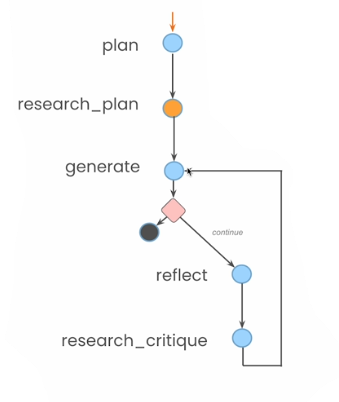

In [7]:
from dotenv import load_dotenv

_ = load_dotenv()

In [8]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory = SqliteSaver.from_conn_string(":memory:")

In [9]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [10]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [11]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [12]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [13]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [14]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [15]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [16]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [17]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [18]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [19]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [20]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [21]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [22]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [23]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [24]:
builder = StateGraph(AgentState)

In [25]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [26]:
builder.set_entry_point("planner")

In [27]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [28]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [29]:
graph = builder.compile(checkpointer=memory)

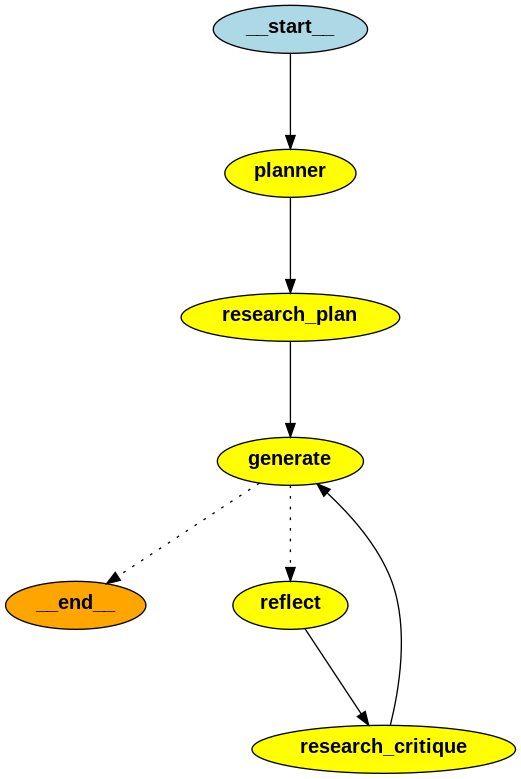

In [30]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [31]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'planner': {'plan': 'I. Introduction\n    A. Brief overview of Langchain and Langsmith\n    B. Thesis statement: Exploring the differences between Langchain and Langsmith\n\nII. Langchain\n    A. Definition and purpose\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and limitations\n\nIII. Langsmith\n    A. Definition and purpose\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and limitations\n\nIV. Comparison between Langchain and Langsmith\n    A. Technology stack\n    B. Scalability and performance\n    C. Security and privacy\n    D. Adoption and popularity\n    E. Future prospects\n\nV. Conclusion\n    A. Recap of main differences between Langchain and Langsmith\n    B. Implications for the blockchain industry\n    C. Final thoughts and recommendations\n\nNotes:\n- Ensure a clear and concise explanation of Langchain and Langsmith in the introduction.\n- Provide specific examples and case

{'reflect': {'critique': "**Critique:**\n\nThe essay provides a clear and structured comparison between LangChain and LangSmith, highlighting their key differences in terms of functionality, target users, and future prospects. The introduction effectively sets the stage for the analysis, and the conclusion succinctly summarizes the main points discussed. The essay successfully outlines the unique characteristics of each tool and their respective strengths and limitations.\n\n**Recommendations:**\n\n1. **Depth and Analysis:** While the essay provides a good overview of LangChain and LangSmith, consider delving deeper into specific examples or case studies to illustrate how each tool is used in real-world scenarios. Providing concrete instances of how developers or AI professionals have benefited from using LangChain and LangSmith would enhance the analysis and make the comparison more tangible.\n\n2. **Expansion on Limitations:** When discussing the limitations of LangChain and LangSmit

{'generate': {'draft': "**Title: Unveiling the Contrasts: LangChain vs. LangSmith**\n\nI. Introduction\n   A. Brief overview of LangChain and LangSmith\n   B. Thesis statement: Exploring the differences between LangChain and LangSmith\n\nII. LangChain\n   A. Definition and purpose\n   B. Key features and characteristics\n   C. Use cases and applications\n   D. Advantages and limitations\n\nIII. LangSmith\n   A. Definition and purpose\n   B. Key features and characteristics\n   C. Use cases and applications\n   D. Advantages and limitations\n\nIV. Comparison between LangChain and LangSmith\n   A. Technology stack\n   B. Scalability and performance\n   C. Security and privacy\n   D. Adoption and popularity\n   E. Future prospects\n\nV. Conclusion\n   A. Recap of main differences between LangChain and LangSmith\n   B. Implications for the blockchain industry\n   C. Final thoughts and recommendations\n\n---\n\nLangChain and LangSmith are two distinct language model software tools that cate

## Essay Writer Interface

In [32]:
import warnings
warnings.filterwarnings("ignore")

from helper import ewriter, writer_gui

In [33]:
MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()

Running on local URL:  http://0.0.0.0:8080
Running on public URL: https://a0252cb3fedeaa3284.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
